# Solar Wind investigation + Classification algorithm

In [291]:
import pandas as pd
import matplotlib.pyplot as plt    

## Data Cleaning and exploration

In [292]:
df = pd.read_csv('solar_wind.csv')
df.head()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac


In [293]:
df.drop([
    'bx_gsm',
    'by_gsm',
    'bz_gsm',
    'density',
    'source',
    'temperature',
    'phi_gsm',
    'theta_gse',
    'phi_gse',
    'theta_gsm',
    'bt',
    'speed'],errors='ignore', axis=1, inplace=True)

In [294]:
df.shape


(8392320, 5)

In [295]:
train_a = df.loc[df['period'] == 'train_a']
train_a.shape

(1729440, 5)

### Drop missing values

In [296]:
clean_train_a = train_a.dropna()

In [297]:
train_a = df.loc[df['period'] == 'train_a']
train_a['bx_gse'].max()


np.float64(41.13)

Interquartile Range

In [298]:
higher_q = clean_train_a['bx_gse'].quantile(0.75)
lower_q = clean_train_a['bx_gse'].quantile(0.25)
iqr = higher_q - lower_q

In [299]:
higher_q + (1.5 * iqr)

np.float64(11.315000000000001)

In [300]:
standard_deviation = train_a['bx_gse'].std()
lower_threshold = standard_deviation * -3.5
higher_threshold = standard_deviation * 3.5
lower_threshold

np.float64(-15.187243210902318)

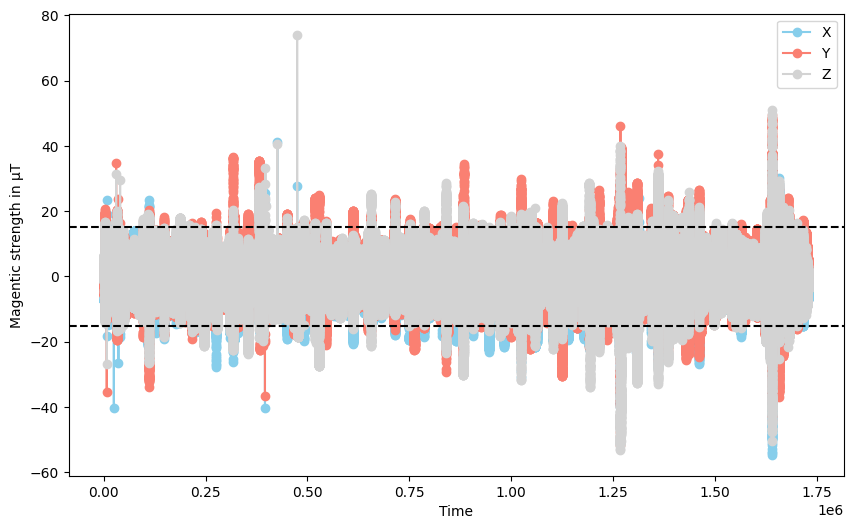

In [244]:
fig, ax = plt.subplots(figsize=(10,6))


ax.plot(clean_train_a.index, clean_train_a['bx_gse'], color= 'skyblue', marker = 'o', label='X')
ax.plot(clean_train_a.index, clean_train_a['by_gse'], color='salmon', marker='o', label='Y')
ax.plot(clean_train_a.index, clean_train_a['bz_gse'], color = 'lightgray', marker='o', label='Z')

ax.axhline(y=higher_threshold, color='black', linestyle='dashed')
ax.axhline(y=lower_threshold, color='black', linestyle = 'dashed')


ax.set_xlabel('Time')
ax.set_ylabel('Magentic strength in μT')


ax.legend()
plt.savefig('plot.png')


### Feature Engineering

In [301]:
filtered_train_a = clean_train_a.dropna()
filtered_train_a.shape

(1575012, 5)

In [302]:
filtered_train_a['Magnitude'] = ((filtered_train_a['bx_gse']**2) + (filtered_train_a['by_gse'] ** 2) + (filtered_train_a['bz_gse'] ** 2)) ** 0.5
filtered_train_a.head()

,period,timedelta,bx_gse,by_gse,bz_gse,Magnitude
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,6.431563
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,6.518504
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,6.374998
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.406622
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,6.324310


In [303]:
standard_deviation = filtered_train_a['Magnitude'].std()
lower_threshold = standard_deviation * -4
higher_threshold = standard_deviation * 4
lower_threshold

np.float64(-14.79410068988208)

In [304]:
#clean_train_a['Irregular_Activity'] = (clean_train_a['bx_gse'] > higher_q + (1.5*iqr) ) | (clean_train_a['bx_gse'] < lower_q - (1.5 * iqr) )
filtered_train_a['Irregular_Activity'] = (filtered_train_a['Magnitude'] > higher_threshold) | (filtered_train_a['Magnitude'] < lower_threshold)
filtered_train_a.loc[filtered_train_a['Irregular_Activity'] == True, ['Magnitude']]

,Magnitude
2788,14.952201
2789,15.364771
2790,15.094787
2791,15.262130
2793,14.871241
...,...
1716911,15.460110
1716912,15.399864
1716913,15.361969
1716914,15.392079


In [305]:
filtered_train_a['filtered_x'] = clean_train_a['bx_gse']

In [306]:
filtered_train_a.loc[filtered_train_a['Irregular_Activity'] == True]

,period,timedelta,bx_gse,by_gse,bz_gse,Magnitude,Irregular_Activity,filtered_x
2788,train_a,1 days 22:28:00,-1.77,9.05,-11.77,14.952201,True,-1.77
2789,train_a,1 days 22:29:00,-2.49,9.95,-11.44,15.364771,True,-2.49
2790,train_a,1 days 22:30:00,-2.26,10.01,-11.07,15.094787,True,-2.26
2791,train_a,1 days 22:31:00,-1.93,9.41,-11.86,15.262130,True,-1.93
2793,train_a,1 days 22:33:00,-2.05,8.37,-12.12,14.871241,True,-2.05
...,...,...,...,...,...,...,...,...
1716911,train_a,1192 days 07:11:00,-8.30,12.75,2.75,15.460110,True,-8.30
1716912,train_a,1192 days 07:12:00,-8.07,12.78,2.95,15.399864,True,-8.07
1716913,train_a,1192 days 07:13:00,-8.35,12.60,2.74,15.361969,True,-8.35
1716914,train_a,1192 days 07:14:00,-8.16,12.68,3.09,15.392079,True,-8.16


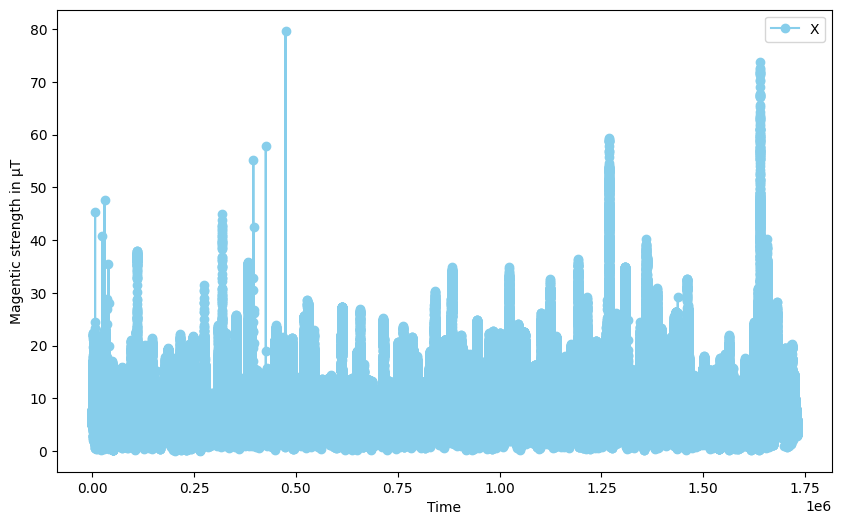

In [272]:
fig, ax = plt.subplots(figsize=(10,6))

mag_high_thresh = 3 * filtered_train_a['Magnitude'] 


ax.plot(filtered_train_a.index, filtered_train_a['Magnitude'], color= 'skyblue', marker = 'o', label='X')





ax.set_xlabel('Time')
ax.set_ylabel('Magentic strength in μT')


ax.legend()
plt.savefig('plot.png')

# Main dataset - Logistic Regression Training

In [307]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [308]:
filtered_train_a.head()

,period,timedelta,bx_gse,by_gse,bz_gse,Magnitude,Irregular_Activity,filtered_x
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,6.431563,False,-5.55
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,6.518504,False,-5.58
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,6.374998,False,-5.15
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.406622,False,-5.20
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,6.324310,False,-5.12


In [309]:
main_dataset = filtered_train_a.drop(['period', 'bx_gse'], axis=1)
main_dataset = main_dataset.dropna()
main_dataset.head()

,timedelta,by_gse,bz_gse,Magnitude,Irregular_Activity,filtered_x
0,0 days 00:00:00,3.00,1.25,6.431563,False,-5.55
1,0 days 00:01:00,3.16,1.17,6.518504,False,-5.58
2,0 days 00:02:00,3.66,0.85,6.374998,False,-5.15
3,0 days 00:03:00,3.68,0.68,6.406622,False,-5.20
4,0 days 00:04:00,3.68,0.49,6.324310,False,-5.12


In [310]:
main_dataset['filtered_x'].max()

np.float64(41.13)

## Data Preprocesing

In [311]:
def duration_to_minutes(duration_str):
    days_part, time_part = duration_str.split(" days ")
    days = int(days_part)
    hours, minutes, seconds = map(int, time_part.split(":"))
    return days * 24 * 60 + hours * 60 + minutes + seconds // 60


main_dataset['minutes'] = df['timedelta'].apply(duration_to_minutes)
main_dataset = main_dataset.drop(['timedelta'], axis=1)
main_dataset.head()



,by_gse,bz_gse,Magnitude,Irregular_Activity,filtered_x,minutes
0,3.00,1.25,6.431563,False,-5.55,0
1,3.16,1.17,6.518504,False,-5.58,1
2,3.66,0.85,6.374998,False,-5.15,2
3,3.68,0.68,6.406622,False,-5.20,3
4,3.68,0.49,6.324310,False,-5.12,4


In [312]:
main_dataset.head()

,by_gse,bz_gse,Magnitude,Irregular_Activity,filtered_x,minutes
0,3.00,1.25,6.431563,False,-5.55,0
1,3.16,1.17,6.518504,False,-5.58,1
2,3.66,0.85,6.374998,False,-5.15,2
3,3.68,0.68,6.406622,False,-5.20,3
4,3.68,0.49,6.324310,False,-5.12,4


In [313]:
X = main_dataset[['filtered_x', 'Magnitude', 'minutes', 'by_gse', 'bz_gse']]
y = main_dataset['Irregular_Activity']

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [315]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Verifying to check mean is 0 and std deviation is 0

In [316]:
print("Mean of scaled training data:", np.mean(X_train_scaled, axis=0))
print("Standard deviation of scaled training data:", np.std(X_train_scaled, axis=0))

Mean of scaled training data: [-4.78541475e-17 -4.04713229e-16 -4.20683409e-18  2.24496066e-17
  1.57107772e-17]
Standard deviation of scaled training data: [1. 1. 1. 1. 1.]


In [317]:
model_balanced = LogisticRegression(class_weight={0:1, 1:4}, random_state=42)
#model_balanced = LogisticRegression(class_weight='balanced', random_state=42)
model_balanced.fit(X_train_scaled, y_train)
wind_prediction = model_balanced.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, wind_prediction))
print("Classification Report:\n", classification_report(y_test, wind_prediction))

Accuracy: 0.9993555616930633
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    302571
        True       0.98      1.00      0.99     12432

    accuracy                           1.00    315003
   macro avg       0.99      1.00      1.00    315003
weighted avg       1.00      1.00      1.00    315003



Support indicates that there is a massive imbalance between the False and True class. I will visualise a pie chart to show ~

Text(0.5, 1.0, 'Imbalance of data between True and False values')

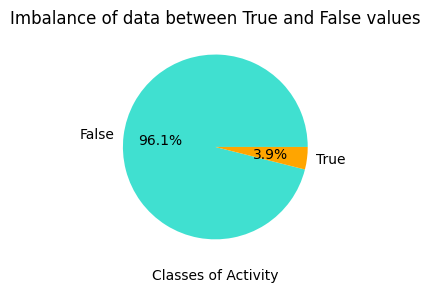

In [318]:
fig, ax = plt.subplots(figsize=(5,3))
true_or_false = main_dataset['Irregular_Activity'].value_counts().reset_index()
labels = ['False', 'True']
ax.pie(true_or_false['count'], labels=labels, colors=['turquoise', 'orange'], autopct='%1.1f%%')
ax.set_xlabel('Classes of Activity')

ax.set_title('Imbalance of data between True and False values')

I will try and test if accuracy is improved if the dataset is more balanced

In [319]:
X = main_dataset[['filtered_x', 'Magnitude', 'minutes', 'by_gse', 'bz_gse']]
y = main_dataset['Irregular_Activity']

Text(0.5, 1.0, 'Imbalance of data between True and False values')

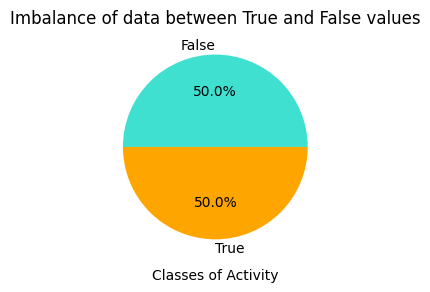

In [320]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(sampling_strategy=1)

X_resize, y_resize = under_sampler.fit_resample(X, y)

fig, ax = plt.subplots(figsize=(5,3))
true_or_false = y_resize.value_counts().reset_index()
ax.pie(true_or_false['count'], labels=labels, colors=['turquoise', 'orange'], autopct='%1.1f%%')
ax.set_xlabel('Classes of Activity')

ax.set_title('Imbalance of data between True and False values')

Now that the proportions are the same, we can test the model again

In [321]:

X_train, X_test, y_train, y_test = train_test_split(X_resize, y_resize, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight={0:1, 1:8}, random_state=42)
model.fit(X_train_scaled, y_train)

wind_prediction = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, wind_prediction))
print("Classification Report:\n", classification_report(y_test, wind_prediction))

Accuracy: 0.9958756216893777
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      1.00     12561
        True       0.99      1.00      1.00     12170

    accuracy                           1.00     24731
   macro avg       1.00      1.00      1.00     24731
weighted avg       1.00      1.00      1.00     24731



Around the same, so I will save the imbalanced model as it is slightly better

In [322]:
import pickle

with open('model.csv','wb') as f:
    pickle.dump(model, f)